In [2]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.axes as ax 
import numpy as np
import tensorflow as tf
from scipy import io
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
import time
import os
import tensorflow.keras.backend as K
import pandas as pd
import Modules.utils as utils
import importlib

In [12]:
importlib.reload(utils)
data_dir='../shared_folder'
writing_dir='../'

Read file and datasets checks

In [ ]:
with np.load(f'{data_dir}/CENPT/raw_data/IP_reads.npz') as f:
    reads = f['reads']
print(reads.shape)
sequences = utils.remove_reads_with_N(reads, tolerance=0)
print(len(sequences))
sequences10 = utils.remove_reads_with_N(reads, tolerance=10)
print(len(sequences10))

In [ ]:
dico = utils.check_read_lengths(reads)
dico = dict(sorted(dico.items(), reverse=True))
print('{read_length: nb_reads}')
print(dico)

In [2]:
with np.load(f'{data_dir}/CENPT/dataset3.npz') as f:
    reads = f['x_train']

In [7]:
print('Looking for read duplicates')
dico = utils.find_duplicates(reads[:10_000_000], one_hot=True, batch_size=5_000_000, print_freq=1_000_000)
values = list(dico.values())
print('Looking for duplicate level duplicates')
dico2 = utils.find_duplicates(values)
dico2 = dict(sorted(dico2.items(), reverse=True))
print('{duplicate_level: nb_unique_reads}')
print(dico2)
print('top 5 duplicate level reads:', list(dico2.keys())[:5])

Looking for read duplicates
Decoding batch 0
seq 1000000/5000000 duplicates
seq 2000000/5000000 duplicates
seq 3000000/5000000 duplicates
seq 4000000/5000000 duplicates
seq 5000000/5000000 duplicates
Decoding batch 1
seq 1000000/5000000 duplicates
seq 2000000/5000000 duplicates
seq 3000000/5000000 duplicates
seq 4000000/5000000 duplicates
seq 5000000/5000000 duplicates
Looking for duplicate level duplicates
{duplicate_level: nb_unique_reads}
{633: 1, 573: 1, 568: 1, 492: 1, 476: 1, 474: 1, 438: 1, 418: 1, 407: 1, 403: 1, 401: 1, 364: 1, 353: 2, 351: 1, 347: 1, 344: 2, 340: 1, 331: 1, 311: 1, 305: 1, 301: 1, 296: 1, 283: 1, 281: 1, 279: 1, 275: 1, 271: 1, 270: 1, 267: 1, 246: 1, 242: 2, 241: 1, 239: 1, 237: 1, 236: 1, 233: 2, 232: 2, 231: 1, 229: 2, 225: 1, 224: 1, 223: 1, 222: 3, 221: 1, 219: 2, 216: 1, 215: 1, 212: 1, 211: 3, 206: 2, 205: 2, 204: 1, 203: 1, 201: 2, 200: 6, 199: 2, 198: 1, 196: 1, 195: 1, 194: 3, 193: 1, 189: 1, 187: 3, 186: 2, 185: 1, 184: 3, 182: 3, 181: 1, 180: 1, 1

In [ ]:
selected_reads = [k for k, v in dico.items() if v == 1896]
print(selected_reads)

In [ ]:
x = list(dico.keys())
y = list(dico.values())
plt.plot(x, y)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('occurences')
plt.xlabel('duplicate level')
plt.show()
plt.close()

In [ ]:
with np.load(f'{data_dir}//Bombyx/dataset3.npz') as dataset:
    y_train = dataset['y_train']
    y_valid = dataset['y_valid']
    y_test = dataset['y_test']
print('total number of reads:',len(y_train) + len(y_valid) + len(y_test))
print('train:', len(y_train), 'valid:', len(y_valid), 'test:', len(y_test))
print('pos_train:', len(y_train[y_train == 1]), 'pos_valid', len(y_valid[y_valid == 1]), 'pos_test', len(y_test[y_test == 1]))

Plot test distribution

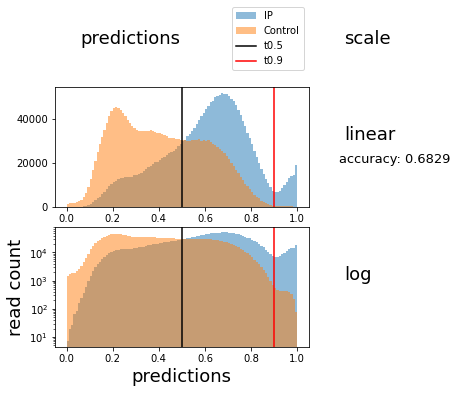

In [14]:
data = 'CTCF'
dataset_name = 'dataset2'
model_name = 'model_inception2.0'
new_labels = 'dataset_rel55'
relabeled = False
single_pred_array = True
if single_pred_array:
    if relabeled:
        with np.load(f'{data_dir}/{data}/results/{model_name}/distrib_{model_name}_test_rel.npz') as f:
            preds = f['pred']
        with np.load(f'{data_dir}//{data}/{new_labels}.npz') as f:
            y_test = f['y_test']
    else:
        with np.load(f'{data_dir}/{data}/results/{model_name}/distrib_{model_name}_test.npz') as f:
            preds = f['pred']
        with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
            y_test = f['y_test']
    predIP = preds[y_test == 1]
    predControl = preds[y_test == 0]
else:
    with np.load(f'{data_dir}/{data}/results/distrib_{model_name}_test.npz') as f:
            predIP = f['predIP']
            predControl = f['predControl']

accuracy =  (len(predIP[predIP > 0.5]) + len(predControl[predControl < 0.5])) / (len(predIP) + len(predControl))
bins = np.histogram(np.concatenate((predIP, predControl)), bins=100)[1]

widths = [5, 1]
heights = [1.2] + [2.5]*2
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'predictions'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'scale'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

for nrow in range(1,3):

    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(predIP, bins, label='IP', alpha=0.5)
    ax0.hist(predControl, bins, label='Control', alpha=0.5)
    ax0.axvline(x=0.5, color='black', label='t0.5')
    thres = 0.9
    ax0.axvline(x=thres, color='red', label=f't{thres}')
    
    ax1 = plt.subplot(gs[nrow, 1])
    if nrow == 1:
        label = 'linear'
        ax1.annotate(f'accuracy: {round(accuracy, 4)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    elif nrow == 2:
        label = 'log'
        ax0.set_yscale('log')
    ax1.annotate(label, (0.1, 0.6), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')
ax0.set_xlabel("predictions", fontsize=18)
ax0.set_ylabel("read count", fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')

if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.mkdir(f'{writing_dir}/{data}/results/{model_name}')
plt.savefig(f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_test.png', bbox_inches='tight')
plt.show()
plt.close()

Select sequences

In [15]:
with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
    x_test = f['x_test']
# thres = 0.55
selected_reads = x_test[preds.ravel() > thres, :, :]
print(f'nb of selected reads with thres {thres}:', len(selected_reads))

nb of selected reads with thres 0.9: 115300


Write into fasta file

In [ ]:
# 3m per 10_000_000 seqs of 101 bp
utils.write_fasta(utils.one_hot_to_seq(selected_reads), f'{writing_dir}/{data}/results/{model_name}/seqs_{data}_over_{thres}_with_{model_name}.fasta')

Plot training logs

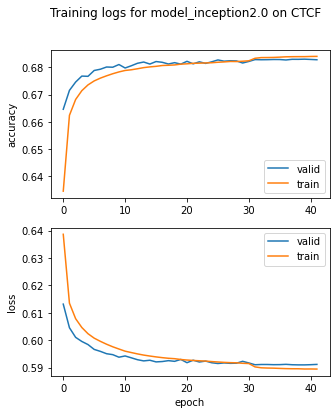

In [16]:
if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.mkdir(f'{writing_dir}/{data}/results/{model_name}/')
logs = pd.read_csv(f'{data_dir}/{data}/Trainedmodels/{model_name}/epoch_data.csv')
fig = plt.figure(figsize=(5, 6))
fig.suptitle(f'Training logs for {model_name} on {data}')
ax0 = plt.subplot(211)
ax0.plot(logs['val_accuracy'], label='valid')
ax0.plot(logs['accuracy'], label='train')
ax0.set_ylabel('accuracy')
ax0.legend()

ax1 = plt.subplot(212)
ax1.plot(logs['val_loss'], label='valid')
ax1.plot(logs['loss'], label='train')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
plt.legend()
plt.savefig(f'{writing_dir}/{data}/results/{model_name}/{model_name}_train_log.png', bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
IP_accuracy = np.size(predIP[predIP > 0.5]) / np.size(predIP)
Control_accuracy = (np.size(predControl[predControl < 0.5])
                    / np.size(predControl))
print('accuracy: ', (IP_accuracy + Control_accuracy) / 2)
print('IP accuracy: ', IP_accuracy)
print('Control accuracy: ', Control_accuracy)

Plot test distribution during epochs

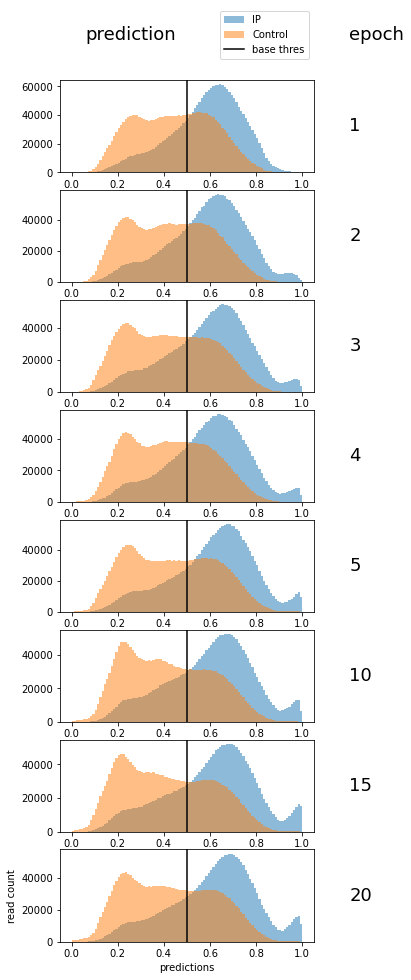

In [20]:
data = 'CTCF'
dataset_name = 'dataset2'
model_name = 'model_inception2.0'
new_labels = 'dataset_rel55'
relabeled = False
preds = np.load(f'{data_dir}/{data}/Trainedmodels/{model_name}/eval_epochs.npy')
# Watching for nan predictions
# for epoch in range(preds.shape[0]):
#     nans = np.count_nonzero(np.isnan(preds[epoch]))
#     print(f'Epoch {epoch}: {nans} nan predictions')
if relabeled:
    with np.load(f'{data_dir}/{data}/{new_labels}.npz') as f:
        y_test = f['y_test']
else:
    with np.load(f'{data_dir}//{data}/{dataset_name}.npz') as f:
        y_test = f['y_test']

# epochs = range(0, preds.shape[0], 5)
epochs = [0, 1, 2, 3, 4, 9, 14, 19]
widths = [5, 1]
heights = [1.2] + [2]*len(epochs)
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} during epochs on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'prediction'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'epoch'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

nrow = 1
for epoch in epochs:
    preds_epoch = preds[epoch]
    predIP = preds_epoch[y_test == 1]
    predControl = preds_epoch[y_test == 0]
    bins = np.histogram(preds_epoch, bins=100, range=(0,1))[1]

    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(predIP, bins, label='IP', alpha=0.5)
    ax0.hist(predControl, bins, label='Control', alpha=0.5)
    ax0.axvline(x=0.5, color='black', label='base thres')

    ax1 = plt.subplot(gs[nrow, 1])
    label = f'{epoch+1}'
    ax1.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')

    nrow += 1

handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')
ax0.set_xlabel("predictions")
ax0.set_ylabel("read count")
if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.mkdir(f'{writing_dir}/{data}/results/{model_name}/')
plt.savefig(f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_train_epochs.png', bbox_inches='tight')
plt.show()
plt.close()

Trying thresholds

In [ ]:
def find_threshold3(pred_pos, pred_neg, choice='first', tolerance=0.9):
    """
    Find the threshold minimizing the misclassification error while satisfying
    a condition on the top cumulative positive rate.

    Misclassification error for threshold t is defined as #{pos<t} + #{neg>t}.
    Top cumulative positive rate (Tcpr) for threshold t is defined as
    #{pos>t} / (#{pos>t} + #{neg>t})

    If the threshold is reached between 2 values, return the mean of these two
    values.
    If the threshold is reached on edges, return median of all values
    The condition for the threshold is Tcpr > tolerance, which defaults to 0.9

    Parameters:
    pred_pos (array_like): list of predictions on positive samples
    pred_neg (array_like): list of predictions on negative samples
    choice (str, optional):
        'first' for first occurence, 'last' for last occurence,
        defaults to 'first'
    tolerance (float, optional): tolerance rate for the Tcpr

    Returns:
    threshold (float): value of the threshold

    Implementation:
    Sort separately positive and negative examples predictions, then sort them
    together by searching incrementally through both lists. While doing so,
    update the misclassification error and top cumulative positive rate. Store
    the minimal error reached so far that satisfies the Tcpr condition, as
    well as the index of the argmin value. The argmin value is the one that
    should be just below the threshold
    """
    pred_neg = np.sort(pred_neg.flatten())
    pred_pos = np.sort(pred_pos.flatten())
    i = 0
    j = 0
    # Store tuple indices, first value is 0 for pred_neg or 1 for pred_pos
    # and second value is the index in the corresponding array
    indices = []
    # At the start, all neg values are misclassified and all pos values are
    # well classified
    error = len(pred_neg)
    min_error = error
    min_error_index = -1  # index in in the "indices" list
    # Store number of positives examples and total number of examples above
    # current position
    top_cur_pos_len = len(pred_pos)
    top_cur_tot_len = len(pred_neg) + len(pred_pos)

    while (i < len(pred_neg)) or (j < len(pred_pos)):
        if i == len(pred_neg):  # End of pred_neg is reached
            indices.append((1, j))  # Fetch next point from pred_pos
            j += 1
            error += 1
            top_cur_pos_len -= 1
        elif j == len(pred_pos):  # End of pred_pos is reached
            indices.append((0, i))  # Fetch next point from pred_neg
            i += 1
            error -= 1
        elif pred_neg[i] < pred_pos[j]:  # Smallest current value
            indices.append((0, i))
            i += 1
            error -= 1
        else:
            indices.append((1, j))
            j += 1
            error += 1
            top_cur_pos_len -= 1
        top_cur_tot_len -= 1
        # compute top cumulative positive rate
        if top_cur_tot_len != 0:
            top_cumul_pos_rate = top_cur_pos_len / top_cur_tot_len
        else:
            top_cumul_pos_rate = 1
        # If error is the lowest so far, update minimal error
        if error < min_error and top_cumul_pos_rate > tolerance:
            min_error = error
            min_error_index = i + j - 1
        elif (choice == 'last'
              and error == min_error
              and top_cumul_pos_rate > tolerance):
            min_error_index = i + j - 1

    if (min_error_index == -1
            or min_error_index == len(pred_neg)+len(pred_pos)-1):
        # If minimum is reached on the edges, return median as default
        median = np.median(np.concatenate((pred_pos, pred_neg)))
        print('median', median)  # ######################################
        return median
    # Otherwise, return the mean of the two points on either side of the
    # threshold
    list_id_below, value_index_below = indices[min_error_index]
    list_id_above, value_index_above = indices[min_error_index+1]
    if list_id_below == 0:  # Take from pred_neg
        value_below = pred_neg[value_index_below]
    else:  # Take from pred_pos
        value_below = pred_pos[value_index_below]
    if list_id_above == 0:
        value_above = pred_neg[value_index_above]
    else:
        value_above = pred_pos[value_index_above]
    threshold = (value_below + value_above) / 2
    return threshold


def find_threshold4(pred_pos, pred_neg, nb_bins=200):
    """
    Find the intersection of the normalized cumulative distribution of pos and
    neg predictions.

    Normalization is performed wrt the area under the cumulative distribution,
    which is not standard normalization

    The threshold is computed through bins, resulting in approximation
    Last intersection is computed

    Parameters:
    pred_pos (array_like): list of predictions on positive samples
    pred_neg (array_like): list of predictions on negative samples
    nb_bins (int, optional): number of bins to divide the range of predictions
        into, default to 200

    Returns:
    threshold (float): value of the threshold
    """
    bins = np.linspace(0, 1, nb_bins)
    pos_bins = np.digitize(pred_pos, bins).flatten()
    pos_count = np.bincount(pos_bins, minlength=len(bins)+1)[1:]
    cumul_pos_count = np.cumsum(pos_count)
    total_pos_count = np.sum(cumul_pos_count)
    cumul_pos_count_norm = cumul_pos_count / total_pos_count
    cumul_pos_count_norm[np.isnan(cumul_pos_count_norm)] = 1

    neg_bins = np.digitize(pred_neg, bins).flatten()
    neg_count = np.bincount(neg_bins, minlength=len(bins)+1)[1:]
    cumul_neg_count = np.cumsum(neg_count)
    total_neg_count = np.sum(cumul_neg_count)
    cumul_neg_count_norm = cumul_neg_count / total_neg_count
    cumul_neg_count_norm[np.isnan(cumul_neg_count_norm)] = 1

    reverse_list = (cumul_pos_count_norm < cumul_neg_count_norm)[::-1]
    index = len(reverse_list) - np.argmax(reverse_list) - 1
    threshold = bins[index]
    return threshold


def PU_threshold(pred_neg_valid):
    """
    Using PU learning insight to choose threshold.
    """
    neg_recall = 1 - np.mean(pred_neg_valid)
    threshold = 1 - neg_recall/2
    return threshold


def threshold6(preds, pred_neg_valid):
    """
    Use PU learning to estimate noise rate, then chose threshold.

    Noise rate is estimated as in PU_threshold, the threshold is set to keep
    as many examples above it as there are true positives
    """
    # Estimate noise rate
    neg_recall = 1 - np.mean(pred_neg_valid)
    tp_estim = 2 - 1 / neg_recall
    # Sort predictions
    preds = np.sort(preds.flatten())
    # Compute index of first value above threshold
    sep = int(len(preds) * (2 - tp_estim) / 2)
    if sep >= len(preds) or sep <= len(preds)/2:
        # If index is out of bounds, return median as default
        median = np.median(preds)
        print('median', median)  # ######################################
        return median
    else:
        # Compute threshold as mean of the values on either side
        thres = (preds[sep-1] + preds[sep]) / 2
        return thres


def threshold7(preds, y, pred_neg_valid):
    """
    Using PU learning to estimate noise rate, then estimate best accuracy.

    Noise rate is estimated as in PU_threshold, accuracy is computed
    considering the top postive predictions as true positives and others as
    false positives. The true positives are weighted to balance classes.

    Implementation:
    Compute number of true positives by rounding from true positive rate and
    number of positives. Compute weights according to the number of true
    positives.
    Sort labels in order of increasing predictions. Compute number of pos and
    neg examples under a given position in the sorted array with cumulative
    sums over the labels. Compute the error by identifying wrongly predicted
    examples. Wrongly predicted examples are:
    - neg examples over;
    - if there are more pos examples over then there are true positives, the
    surplus of positives are wrong;
    - otherwise the remaining true positives under are wrong with weighted
    contribution to the error
    The argmin value should be the one just below the threshold. Since the
    predictions weren't sorted, fetch the predictions corresponding to given
    index using the stored order from argsort.
    """
    # Estimate noise rate
    neg_recall = 1 - np.mean(pred_neg_valid)
    tp_estim = 2 - 1 / neg_recall
    # Number of positives and true positives
    pos_len = len(y[y == 1])
    n_tp_estim = round(pos_len * tp_estim)
    # Weight of true positives to balance classes
    weight_tp = (len(y) - n_tp_estim) / n_tp_estim
    # Sort arrays
    preds, y = preds.flatten(), y.flatten()
    order = np.argsort(preds)
    y = y[order]
    # Compute the number of pos and neg examples on either side of thres for
    # every position of thres
    neg_under = np.cumsum(1 - y)
    neg_over = len(y) - pos_len - neg_under
    pos_under = np.cumsum(y)
    pos_over = pos_len - pos_under
    # Estimate error at each position, and extract minimum
    error = np.where(n_tp_estim <= pos_over,
                     neg_over + pos_over - n_tp_estim,
                     neg_over + weight_tp*(n_tp_estim - pos_over))
    min_error_index = np.argmin(error)
    if min_error_index == len(y) - 1:
        # If minimum is reached at the end, return median as default
        median = np.median(preds)
        print('median', median)  # ######################################
        return median
    else:
        # compute threshold as mean of the values on either side
        thres = (preds[order[min_error_index]]
                 + preds[order[min_error_index+1]]) / 2
        return thres


In [ ]:
with np.load('H3K27ac/results/distrib_model_inception_train.npz') as f:
    predIP_tr = f['predIP_train']
    predControl_tr = f['predControl_train']
    predControl_v = f['predControl_valid']
with np.load('H3K27ac/dataset.npz') as f:
    y_train = f['y_train']
preds = np.concatenate((predIP_tr, predControl_tr))
y = np.concatenate((np.ones(len(predIP_tr)), np.zeros(len(predControl_tr))))

In [ ]:
t0 = time.time()
t6 = threshold6(preds, predControl_v)
print('t6:', time.time() - t0)
t0 = time.time()
t7 = threshold7(preds, y, predControl_v)
print('t7:', time.time() - t0)
t0 = time.time()
t3 = find_threshold3(predIP_tr, predControl_tr)
print('t3:', time.time() - t0)
t0 = time.time()
t_PU = PU_threshold(predControl_v)
print('t_PU:', time.time() - t0)

In [ ]:
tp_estim = 2 - 0.5 / (1 - t_PU) # estimation of the true positive rate with tPU
print(tp_estim)

In [ ]:
bins = np.histogram(np.concatenate((predIP_tr, predControl_tr)), bins=100)[1]
plt.figure()
plt.hist(predIP_tr,bins,label='IP',alpha=0.5)
plt.hist(predControl_tr,bins,label='Control',alpha=0.5)
plt.axvline(t_PU, label='tPU', color='black')
plt.axvline(t3, label='t3', color='blue')
plt.axvline(t6, label='t6', color='green')
plt.axvline(t7, label='t7', color='red')
plt.title("Distribution of the probability outputs for IP and Control reads")
plt.xlabel("Probability")
plt.ylabel("bin count")
plt.legend()
plt.show()
plt.close()

In [ ]:
nb_bins = 200
bins = np.linspace(0,1,nb_bins)
IP_bins = np.digitize(predIP, bins).flatten()
IP_count = np.bincount(IP_bins, minlength=len(bins)+1)[1:]
Control_bins = np.digitize(predControl, bins).flatten()
Control_count = np.bincount(Control_bins, minlength=len(bins)+1)[1:]
total_count = IP_count + Control_count
IP_rate = IP_count / total_count

In [ ]:
top_cumul_IP_count = np.flip(np.cumsum(np.flip(IP_count)))
top_cumul_total_count = np.flip(np.cumsum(np.flip(total_count)))
top_cumul_IP_rate = top_cumul_IP_count / top_cumul_total_count

In [ ]:
plt.figure()
plt.hist(predIP, bins=200, label='IP', weights=20*np.ones(len(predIP)) / len(predIP), alpha=0.5)
plt.hist(predControl, bins=200, label='Control', weights=20*np.ones(len(predControl)) / len(predControl), alpha=0.5)
plt.plot(bins, IP_rate, label='IP rate')
plt.plot(bins, top_cumul_IP_rate, label='cumulative IP rate from top', color='black')
plt.axhline(y=0.9,label='0.9 rate limit', color='red')
plt.title("rate of IP reads per prediction value")
plt.xlabel("Prediction")
plt.ylabel("rate")
plt.legend()
plt.show()
plt.close()

Plot GC_content distribution

In [ ]:
data='NONO'
dataset_name='dataset2'
with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
    x_test = f['x_test']
    y_test = f['y_test']
gc_content = utils.GC_content(x_test)

bins = np.histogram(gc_content, bins=100, range=(0, 1))[1]
accuracy, thres = utils.classify_1D(gc_content, y_test, bins=100)
print('accuracy :', accuracy)

widths = [5, 1]
heights = [1.2] + [2.5]*2
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'GC content'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'scale'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

for nrow in range(1,3):

    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(gc_content[y_test == 1], bins, label='IP', alpha=0.5)
    ax0.hist(gc_content[y_test == 0], bins, label='Control', alpha=0.5)
    ax0.axvline(x=thres, color='black', label='thres')
    
    ax1 = plt.subplot(gs[nrow, 1])
    if nrow == 1:
        scale_label = 'linear'
        ax1.annotate(f'accuracy: {round(accuracy, 4)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    elif nrow == 2:
        scale_label = 'log'
        ax0.set_yscale('log')
    ax1.annotate(scale_label, (0.1, 0.6), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')
ax0.set_xlabel("GC content", fontsize=18)
ax0.set_ylabel("read count", fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')

fig.suptitle(f'Distribution of GC content in {data} reads', fontsize=18)
plt.savefig(f'{writing_dir}/{data}/results/gc_content_classification_{dataset_name}.png', bbox_inches='tight')
plt.show()
plt.close()